# Phase 4: SHAP Explainability Analysis (Google Colab)

**Objective**: Use SHAP (SHapley Additive exPlanations) to explain model predictions and understand feature importance.

**Key Goals:**
- Generate SHAP values for best model predictions
- Visualize global feature importance
- Analyze individual prediction explanations
- Understand feature interactions


In [1]:
# Check GPU availability
!nvidia-smi

Thu Jan 15 12:13:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install required libraries
!pip install catboost shap

print("\nLibraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00

Libraries installed successfully!


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("\nGoogle Drive mounted!")
print("Files will be loaded from: /content/drive/MyDrive/lottery_analyzer/")

Mounted at /content/drive

Google Drive mounted!
Files will be loaded from: /content/drive/MyDrive/lottery_analyzer/


## 1. Path Configuration

In [4]:
# Choose your data source
USE_GOOGLE_DRIVE = True  # Set to False if uploading directly to Colab

if USE_GOOGLE_DRIVE:
    DATA_DIR = '/content/drive/MyDrive/lottery_analyzer/data/splits'
    OUTPUT_DIR = '/content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap'
    MODEL_DIR = '/content/drive/MyDrive/lottery_analyzer/models'
else:
    DATA_DIR = '/content/data/splits'
    OUTPUT_DIR = '/content/outputs/explainability/shap'
    MODEL_DIR = '/content/models'

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")

Data directory: /content/drive/MyDrive/lottery_analyzer/data/splits
Output directory: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap
Model directory: /content/drive/MyDrive/lottery_analyzer/models


## 2. Setup and Imports

In [5]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# CatBoost
import catboost
from catboost import CatBoostClassifier

# SHAP
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully")
print(f"CatBoost version: {catboost.__version__}")
print(f"SHAP version: {shap.__version__}")

Libraries imported successfully
CatBoost version: 1.2.8
SHAP version: 0.50.0


## 3. Load Best Model

In [6]:
# Define paths
DATA_DIR = Path(DATA_DIR)
OUTPUT_DIR = Path(OUTPUT_DIR)
MODEL_DIR = Path(MODEL_DIR)

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load best model
best_model = CatBoostClassifier()
best_model.load_model(str(MODEL_DIR / 'best_model.cbm'))

print("Best model loaded successfully")
print(f"Model iterations: {best_model.tree_count_}")

Best model loaded successfully
Model iterations: 14


## 4. Load Test Data

In [7]:
# Get all lottery names
test_files = sorted(DATA_DIR.glob('*_test.csv'))
lottery_names = [f.stem.replace('_test', '') for f in test_files]

print(f"Found {len(lottery_names)} lotteries")

# Load all test data
test_dfs = []
for lottery in lottery_names:
    df = pd.read_csv(DATA_DIR / f"{lottery}_test.csv")
    test_dfs.append(df)

test_data = pd.concat(test_dfs, ignore_index=True)

print(f"Test data shape: {test_data.shape}")
print(f"\nClass distribution:")
print(test_data['appeared'].value_counts())

Found 17 lotteries
Test data shape: (72769, 25)

Class distribution:
appeared
0    67892
1     4877
Name: count, dtype: int64


## 5. Prepare Features

In [8]:
# Define feature columns (exclude target and identifiers)
exclude_cols = ['appeared', 'draw_date', 'lottery', 'number']
feature_cols = [col for col in test_data.columns if col not in exclude_cols]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

# Prepare X and y
X_test = test_data[feature_cols]
y_test = test_data['appeared']

print(f"\nX_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Feature columns (21):
['draw_id', 'draw_sequence', 'frequency_last_10', 'frequency_last_30', 'frequency_last_50', 'frequency_all_time', 'appearance_rate', 'days_since_last', 'day_of_week', 'is_weekend', 'month', 'week_of_year', 'mean_gap', 'std_gap', 'min_gap', 'max_gap', 'current_gap', 'temperature_score', 'is_hot', 'is_cold', 'trend']

X_test shape: (72769, 21)
y_test shape: (72769,)


## 6. Create SHAP Explainer

We'll use TreeExplainer, which is optimized for tree-based models like CatBoost.

In [9]:
print("Creating SHAP TreeExplainer...")
print("This may take a few minutes...\n")

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

print("SHAP explainer created successfully")

Creating SHAP TreeExplainer...
This may take a few minutes...

SHAP explainer created successfully


## 7. Calculate SHAP Values

For efficiency, we'll calculate SHAP values on a sample of the test set (10,000 instances).

In [10]:
# Use a sample for faster computation
SAMPLE_SIZE = 10000
np.random.seed(42)

if len(X_test) > SAMPLE_SIZE:
    sample_indices = np.random.choice(len(X_test), SAMPLE_SIZE, replace=False)
    X_sample = X_test.iloc[sample_indices]
    y_sample = y_test.iloc[sample_indices]
else:
    X_sample = X_test
    y_sample = y_test

print(f"Calculating SHAP values for {len(X_sample)} samples...")
print("This may take 2-5 minutes...\n")

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values calculated successfully")
print(f"SHAP values shape: {shap_values.shape}")

# Save SHAP values for later analysis
np.save(OUTPUT_DIR / 'shap_values.npy', shap_values)
X_sample.to_csv(OUTPUT_DIR / 'shap_sample_data.csv', index=False)
print(f"\nSaved SHAP values to: {OUTPUT_DIR / 'shap_values.npy'}")

Calculating SHAP values for 10000 samples...
This may take 2-5 minutes...

SHAP values calculated successfully
SHAP values shape: (10000, 21)

Saved SHAP values to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_values.npy


## 8. SHAP Summary Plot (Global Feature Importance)

This plot shows which features are most important across all predictions.

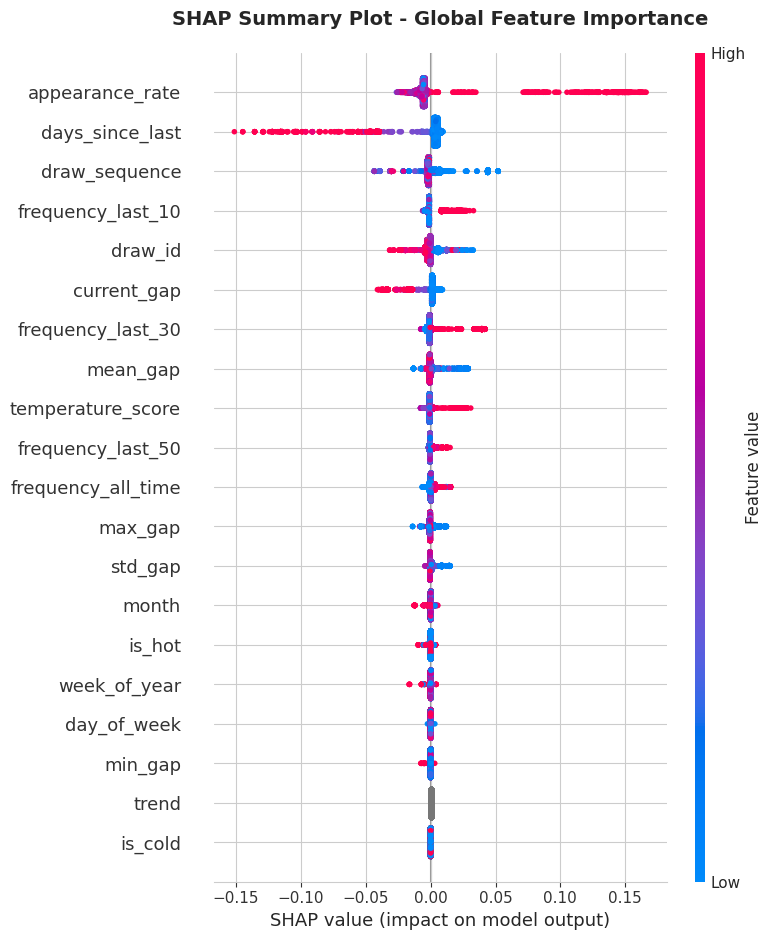

Saved SHAP summary plot to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_summary_plot.png


In [11]:
# Summary plot (beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved SHAP summary plot to: {OUTPUT_DIR / 'shap_summary_plot.png'}")

## 9. SHAP Bar Plot (Mean Absolute SHAP Values)

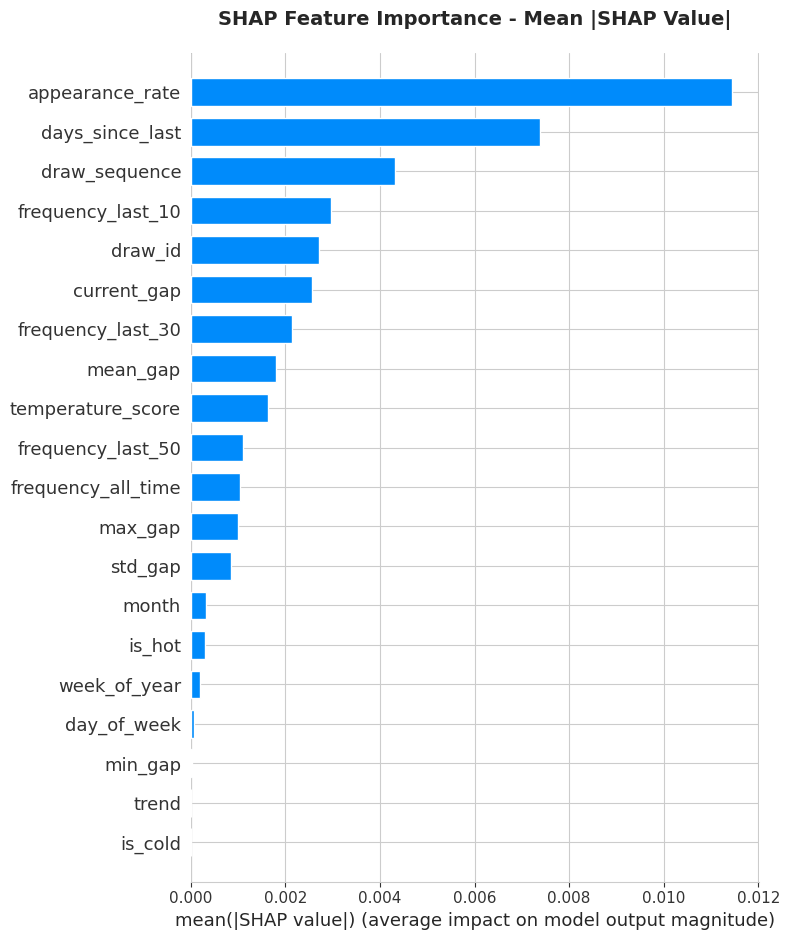

Saved SHAP bar plot to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_bar_plot.png


In [12]:
# Bar plot showing mean absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance - Mean |SHAP Value|', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved SHAP bar plot to: {OUTPUT_DIR / 'shap_bar_plot.png'}")

## 10. Feature Importance Ranking

In [13]:
# Calculate mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Create DataFrame
shap_importance_df = pd.DataFrame({
    'feature': X_sample.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 15 Most Important Features (SHAP):")
print(shap_importance_df.head(15).to_string(index=False))

# Save to CSV
shap_importance_df.to_csv(OUTPUT_DIR / 'shap_feature_importance.csv', index=False)
print(f"\nSaved SHAP feature importance to: {OUTPUT_DIR / 'shap_feature_importance.csv'}")


Top 15 Most Important Features (SHAP):
           feature  mean_abs_shap
   appearance_rate       0.011439
   days_since_last       0.007379
     draw_sequence       0.004321
 frequency_last_10       0.002964
           draw_id       0.002718
       current_gap       0.002566
 frequency_last_30       0.002140
          mean_gap       0.001807
 temperature_score       0.001631
 frequency_last_50       0.001111
frequency_all_time       0.001046
           max_gap       0.000994
           std_gap       0.000850
             month       0.000321
            is_hot       0.000297

Saved SHAP feature importance to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_feature_importance.csv


## 11. SHAP Dependence Plots (Top 5 Features)

Dependence plots show how feature values relate to SHAP values (impact on prediction).

Creating SHAP dependence plots for top 5 features...
Top 5 features: ['appearance_rate', 'days_since_last', 'draw_sequence', 'frequency_last_10', 'draw_id']



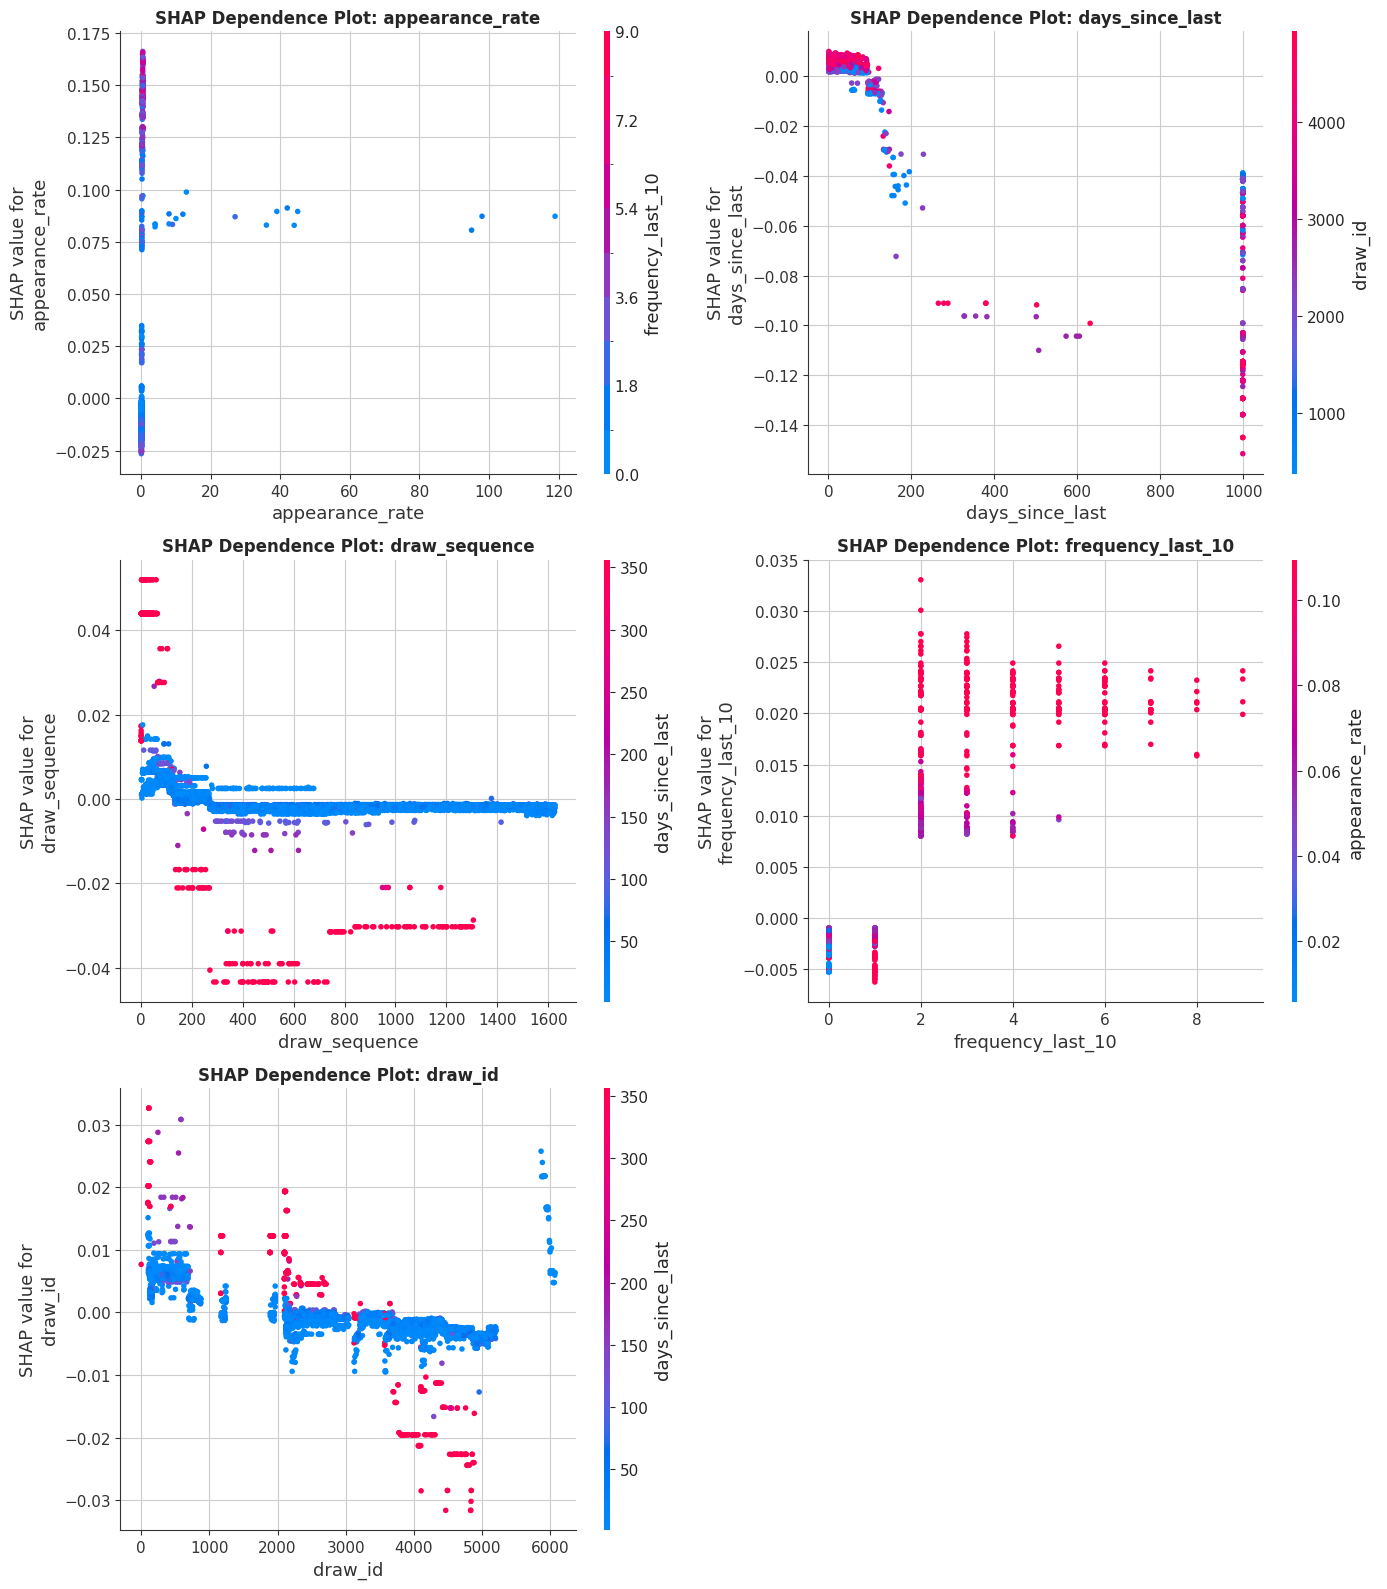

Saved SHAP dependence plots to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_dependence_plots.png


In [14]:
# Get top 5 features
top_5_features = shap_importance_df.head(5)['feature'].tolist()

print(f"Creating SHAP dependence plots for top 5 features...")
print(f"Top 5 features: {top_5_features}\n")

# Create dependence plots
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
axes = axes.flatten()

for idx, feature in enumerate(top_5_features):
    shap.dependence_plot(
        feature,
        shap_values,
        X_sample,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence Plot: {feature}', fontsize=12, fontweight='bold')

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved SHAP dependence plots to: {OUTPUT_DIR / 'shap_dependence_plots.png'}")

## 12. SHAP Force Plot (Individual Prediction Examples)

Force plots show how features contribute to individual predictions.

Creating SHAP force plots for example predictions...

Example 1: Instance 2 (Actual: Appeared)


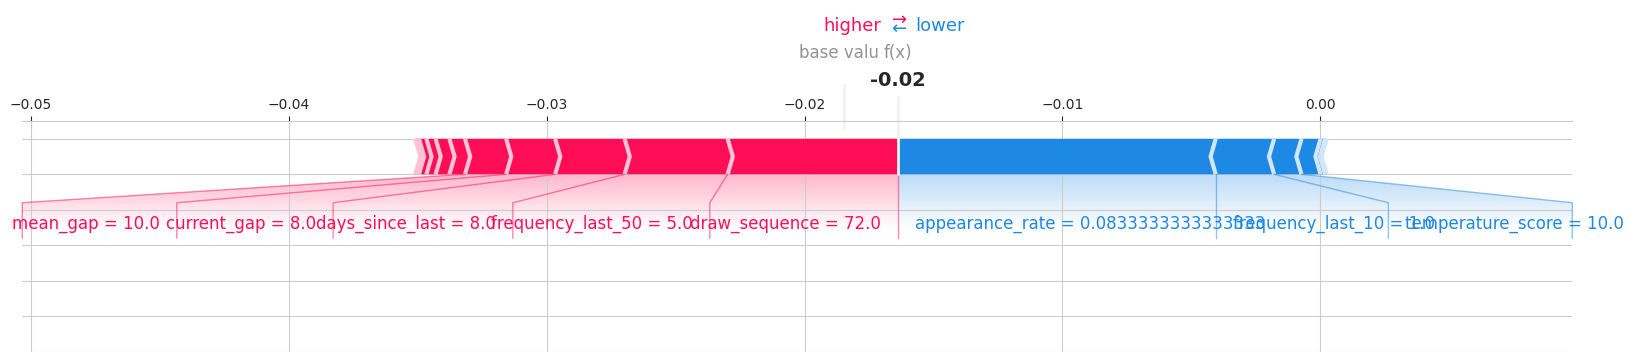


Example 2: Instance 0 (Actual: Not Appeared)


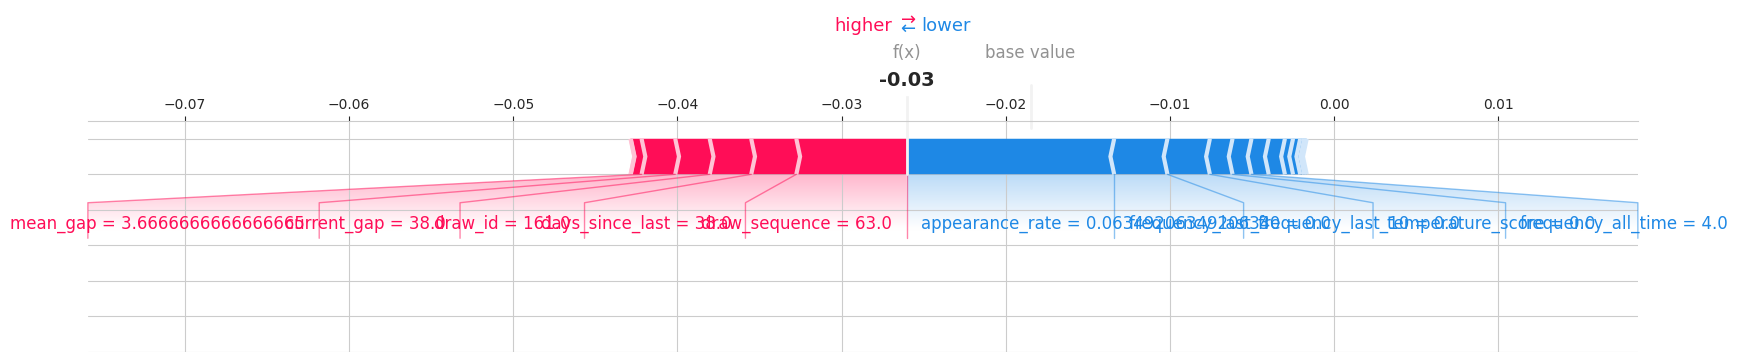


Saved SHAP force plots to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap


In [15]:
# Initialize SHAP JavaScript for interactive plots
shap.initjs()

print("Creating SHAP force plots for example predictions...\n")

# Example 1: High confidence positive prediction
positive_indices = np.where(y_sample == 1)[0]
if len(positive_indices) > 0:
    example_idx_pos = positive_indices[0]
    print(f"Example 1: Instance {example_idx_pos} (Actual: Appeared)")
    shap.force_plot(
        explainer.expected_value,
        shap_values[example_idx_pos],
        X_sample.iloc[example_idx_pos],
        matplotlib=True,
        show=False
    )
    plt.savefig(OUTPUT_DIR / 'shap_force_plot_positive.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example 2: High confidence negative prediction
negative_indices = np.where(y_sample == 0)[0]
if len(negative_indices) > 0:
    example_idx_neg = negative_indices[0]
    print(f"\nExample 2: Instance {example_idx_neg} (Actual: Not Appeared)")
    shap.force_plot(
        explainer.expected_value,
        shap_values[example_idx_neg],
        X_sample.iloc[example_idx_neg],
        matplotlib=True,
        show=False
    )
    plt.savefig(OUTPUT_DIR / 'shap_force_plot_negative.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"\nSaved SHAP force plots to: {OUTPUT_DIR}")

## 13. SHAP Waterfall Plot (Alternative Individual Explanation)

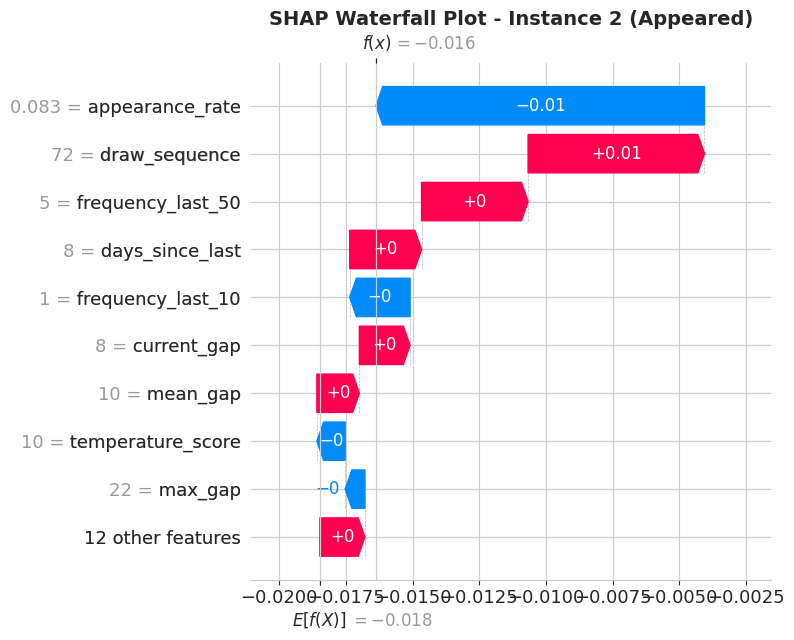

Saved SHAP waterfall plot to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_waterfall_plot_positive.png


In [16]:
# Waterfall plot for first positive example
if len(positive_indices) > 0:
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[example_idx_pos],
            base_values=explainer.expected_value,
            data=X_sample.iloc[example_idx_pos].values,
            feature_names=X_sample.columns.tolist()
        ),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Instance {example_idx_pos} (Appeared)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'shap_waterfall_plot_positive.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved SHAP waterfall plot to: {OUTPUT_DIR / 'shap_waterfall_plot_positive.png'}")

## 14. Compare SHAP Importance with CatBoost Feature Importance

In [17]:
# Load CatBoost feature importance
catboost_importance = pd.read_csv(MODEL_DIR.parent / 'outputs' / 'results' / 'catboost_feature_importance.csv')

# Normalize both importance scores to 0-100
catboost_importance['importance_normalized'] = (
    catboost_importance['importance'] / catboost_importance['importance'].max() * 100
)
shap_importance_df['importance_normalized'] = (
    shap_importance_df['mean_abs_shap'] / shap_importance_df['mean_abs_shap'].max() * 100
)

# Merge
comparison_df = catboost_importance.merge(
    shap_importance_df[['feature', 'importance_normalized']],
    on='feature',
    suffixes=('_catboost', '_shap')
).sort_values('importance_normalized_shap', ascending=False)

print("\nComparison of CatBoost vs SHAP Feature Importance (Top 15):")
print(comparison_df[['feature', 'importance_normalized_catboost', 'importance_normalized_shap']].head(15).to_string(index=False))

# Save comparison
comparison_df.to_csv(OUTPUT_DIR / 'importance_comparison.csv', index=False)
print(f"\nSaved comparison to: {OUTPUT_DIR / 'importance_comparison.csv'}")


Comparison of CatBoost vs SHAP Feature Importance (Top 15):
           feature  importance_normalized_catboost  importance_normalized_shap
   appearance_rate                       43.429030                  100.000000
   days_since_last                       57.993447                   64.513410
     draw_sequence                      100.000000                   37.778602
 frequency_last_10                        2.208261                   25.914608
           draw_id                       23.724577                   23.760471
       current_gap                       69.359906                   22.432621
 frequency_last_30                        6.973578                   18.705749
          mean_gap                        3.681354                   15.799103
 temperature_score                        7.803361                   14.257673
 frequency_last_50                        3.326172                    9.711025
frequency_all_time                        2.243485                    

## 15. Visualize Importance Comparison

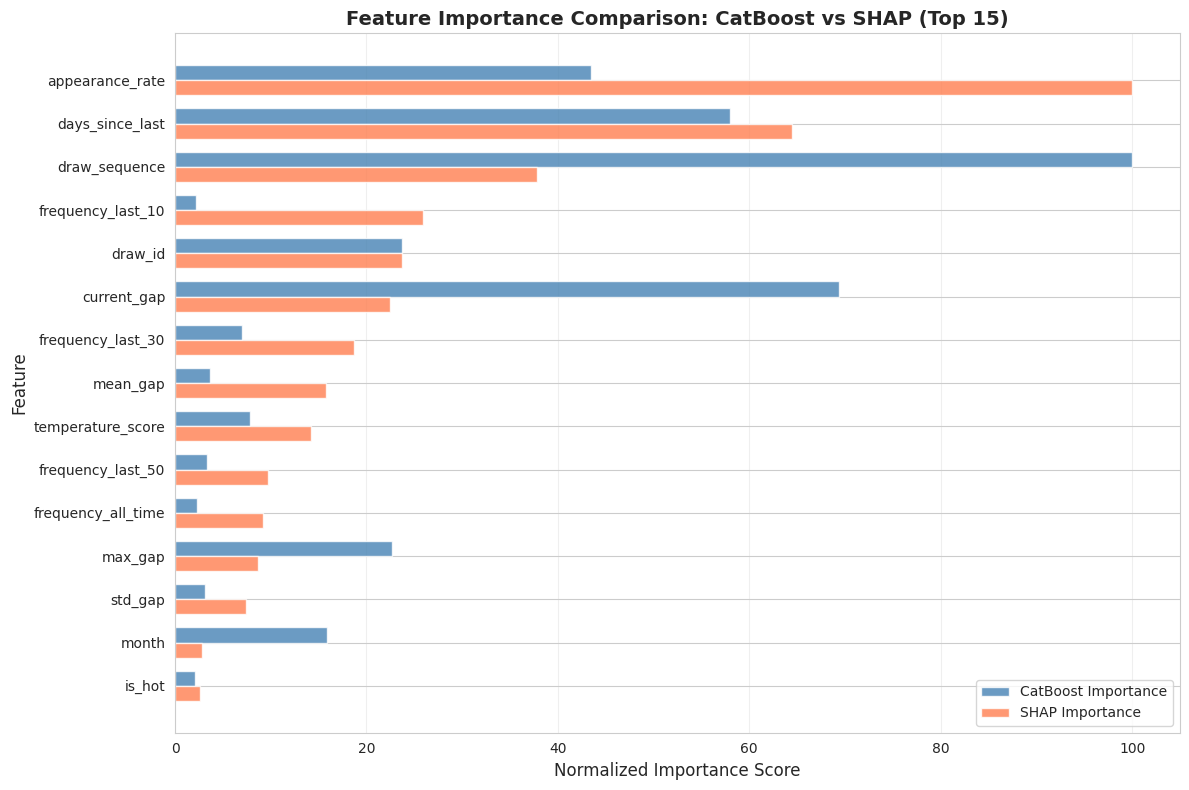

Saved importance comparison plot to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/importance_comparison_plot.png


In [18]:
# Plot comparison of top 15 features
top_15_comparison = comparison_df.head(15)

fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(top_15_comparison))
width = 0.35

bars1 = ax.barh(x - width/2, top_15_comparison['importance_normalized_catboost'], width,
                label='CatBoost Importance', color='steelblue', alpha=0.8)
bars2 = ax.barh(x + width/2, top_15_comparison['importance_normalized_shap'], width,
                label='SHAP Importance', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_15_comparison['feature'])
ax.set_xlabel('Normalized Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance Comparison: CatBoost vs SHAP (Top 15)', fontsize=14, fontweight='bold')
ax.legend()
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'importance_comparison_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved importance comparison plot to: {OUTPUT_DIR / 'importance_comparison_plot.png'}")

## 16. Generate SHAP Analysis Report

In [19]:
# Generate summary report
report = {
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_file': 'best_model.cbm',
    'sample_size': len(X_sample),
    'total_features': len(X_sample.columns),
    'top_5_features_shap': top_5_features,
    'top_5_features_catboost': catboost_importance.head(5)['feature'].tolist(),
    'mean_abs_shap_values': {
        feature: float(shap_importance_df[shap_importance_df['feature'] == feature]['mean_abs_shap'].values[0])
        for feature in top_5_features
    },
    'outputs_generated': [
        'shap_values.npy',
        'shap_sample_data.csv',
        'shap_summary_plot.png',
        'shap_bar_plot.png',
        'shap_feature_importance.csv',
        'shap_dependence_plots.png',
        'shap_force_plot_positive.png',
        'shap_force_plot_negative.png',
        'shap_waterfall_plot_positive.png',
        'importance_comparison.csv',
        'importance_comparison_plot.png'
    ]
}

# Save report
with open(OUTPUT_DIR / 'shap_analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print("\n" + "="*60)
print("SHAP ANALYSIS COMPLETE")
print("="*60)
print(f"\nAnalysis Date: {report['analysis_date']}")
print(f"Sample Size: {report['sample_size']:,}")
print(f"Total Features: {report['total_features']}")
print(f"\nTop 5 Features (SHAP):")
for i, feature in enumerate(report['top_5_features_shap'], 1):
    print(f"  {i}. {feature}")
print(f"\nOutputs saved to: {OUTPUT_DIR}")
print(f"Total files generated: {len(report['outputs_generated'])}")
print(f"\nReport saved to: {OUTPUT_DIR / 'shap_analysis_report.json'}")


SHAP ANALYSIS COMPLETE

Analysis Date: 2026-01-15 12:18:38
Sample Size: 10,000
Total Features: 21

Top 5 Features (SHAP):
  1. appearance_rate
  2. days_since_last
  3. draw_sequence
  4. frequency_last_10
  5. draw_id

Outputs saved to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap
Total files generated: 11

Report saved to: /content/drive/MyDrive/lottery_analyzer/outputs/explainability/shap/shap_analysis_report.json


## 17. Key Insights Summary

In [20]:
print("\n" + "="*60)
print("KEY INSIGHTS FROM SHAP ANALYSIS")
print("="*60)

print("\n1. GLOBAL FEATURE IMPORTANCE:")
print("   The SHAP summary plot reveals which features consistently")
print("   impact predictions across all instances.")

print("\n2. FEATURE VALUE RELATIONSHIPS:")
print("   SHAP dependence plots show how different feature values")
print("   affect the model's predictions (positive or negative impact).")

print("\n3. INDIVIDUAL PREDICTIONS:")
print("   Force plots and waterfall plots explain why the model")
print("   made specific predictions for individual lottery numbers.")

print("\n4. MODEL INTERPRETABILITY:")
print("   - SHAP values provide magnitude and direction of impact")
print("   - CatBoost importance shows split-based importance")
print("   - Both metrics help validate feature engineering choices")

print("\n5. NEXT STEPS:")
print("   - Review SHAP plots to understand model behavior")
print("   - Document findings in assignment report")
print("   - Use insights to explain model decisions to stakeholders")
print("   - Consider feature engineering refinements if needed")

print("\n" + "="*60)


KEY INSIGHTS FROM SHAP ANALYSIS

1. GLOBAL FEATURE IMPORTANCE:
   The SHAP summary plot reveals which features consistently
   impact predictions across all instances.

2. FEATURE VALUE RELATIONSHIPS:
   SHAP dependence plots show how different feature values
   affect the model's predictions (positive or negative impact).

3. INDIVIDUAL PREDICTIONS:
   Force plots and waterfall plots explain why the model
   made specific predictions for individual lottery numbers.

4. MODEL INTERPRETABILITY:
   - SHAP values provide magnitude and direction of impact
   - CatBoost importance shows split-based importance
   - Both metrics help validate feature engineering choices

5. NEXT STEPS:
   - Review SHAP plots to understand model behavior
   - Document findings in assignment report
   - Use insights to explain model decisions to stakeholders
   - Consider feature engineering refinements if needed

